Extract features from EmoDB dataset

In [1]:
import librosa
import os
import numpy as np
import pandas as pd

# Example fetures extraction

In [20]:
example_audio = '/datasets/nicolas_facchinetti/EMOVO/data/m1/dis-m1-l1.wav'
samples, sample_rate = librosa.load(example_audio, sr=None)

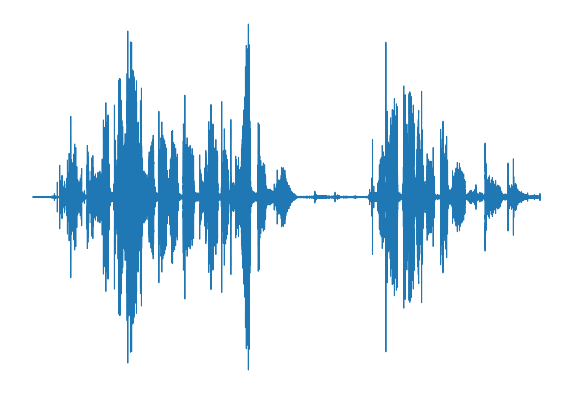

In [21]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.axis('off')
librosa.display.waveshow(samples, sr=sample_rate)

In [14]:
from IPython.display import Audio
Audio(samples, rate=sample_rate)

/home/nicolas/.conda/envs/thesis/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


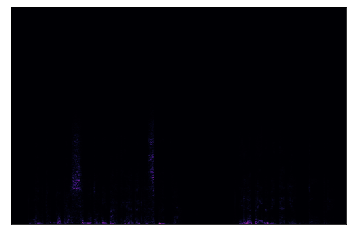

In [15]:
# convert to spectrogram
sgram = librosa.stft(samples, n_fft=2048, hop_length=512)
librosa.display.specshow(sgram)

/tmp/ipykernel_1603528/29967690.py:2: FutureWarning: Pass y=[-7.6293945e-05  3.6621094e-04  1.0681152e-04 ...  2.4414062e-03
  2.6550293e-03  2.7923584e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_scale_sgram = librosa.feature.melspectrogram(samples, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=64)


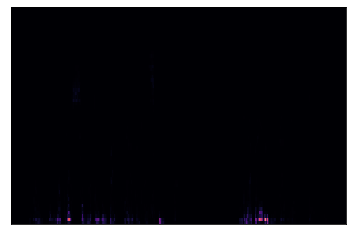

In [16]:
# use the mel-scale instead of raw frequency
mel_scale_sgram = librosa.feature.melspectrogram(samples, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=64)
librosa.display.specshow(mel_scale_sgram)

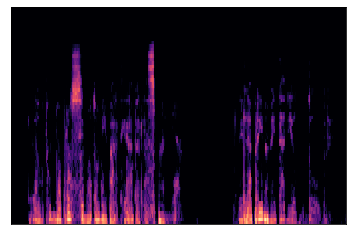

In [17]:
# use the decibel scale to get the final Mel Spectrogram
log_mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

librosa.display.specshow(log_mel_sgram, sr=sample_rate)

# DataFrame with Input Samples

Create Pandas DataFrame with filename and label

In [29]:
label2name = {
    "dis": "disgusto",
    "neu": "neutro",
    "gio": "gioia",
    "pau": "paura",
    "tri": "tristezza",
    "rab": "rabbia",
    "sor": "sorpresa",
}


dir_path = '/datasets/nicolas_facchinetti/EMOVO/data'
data = []
samples_list = []
for actor in os.listdir(dir_path):
    path = dir_path+f"/{actor}"
    for filename in os.listdir(path):
        samples, sr = librosa.load(os.path.join(path, filename), sr=None)
        samples_list.append(samples)
        length = len(samples)/sr
    
        cat = filename[0:3]
        data.append([filename, cat, actor, actor[0], length])
    
    
df_info = pd.DataFrame(data, columns=['filename', 'label', 'actor', 'gender', 'length'])
df_info
    

,filename,label,actor,gender,length
0,gio-m3-l1.wav,gio,m3,m,5.205333
1,gio-m3-b3.wav,gio,m3,m,1.877333
2,pau-m3-n5.wav,pau,m3,m,4.394667
3,tri-m3-b2.wav,tri,m3,m,2.773333
4,tri-m3-l4.wav,tri,m3,m,3.370667
...,...,...,...,...,...
583,dis-m2-b3.wav,dis,m2,m,2.474667
584,sor-m2-d1.wav,sor,m2,m,2.090667
585,pau-m2-b3.wav,pau,m2,m,1.962667
586,tri-m2-n2.wav,tri,m2,m,2.368000


Deal with different lenghts

In [30]:
df_info["length"].describe()

count    588.000000
mean       3.120986
std        1.357110
min        1.290667
25%        2.133333
50%        2.773333
75%        3.840000
max       13.994667
Name: length, dtype: float64

Let's keep a length of 3.84, pad the shorter while split the longer. Throw away samples below minimum lenght 1.29

In [50]:
buffer_length = 3.84*sample_rate
padded = librosa.util.pad_center(samples_list[1], size=buffer_length)
padded, len(padded)/sample_rate

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 3.84)

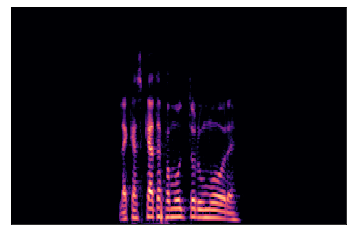

In [51]:
mels = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
log = librosa.amplitude_to_db(mels, ref=np.min)
librosa.display.specshow(log, sr=sample_rate)

In [52]:
def split_sample(audio, length, minimum):
    samples_total = len(audio)
    samples_wrote = 0
    segments = []
    
    to_process = samples_total - samples_wrote
    while to_process > minimum:
        segment = audio[samples_wrote : (samples_wrote + length)]
        segments.append(segment)
        samples_wrote += length
        to_process = samples_total - samples_wrote
    return segments

# Dataset processing

Split and pad all the samples, then extract log Mel-specotrograms from all the samples

In [47]:
mod_samples = []
sgram_list = []
mod_data = []
for count, samples in enumerate(samples_list):
    metadata = df_info.iloc[count]
    
    # split larger segmtents
    samples = [samples]
    if metadata["length"] >= buffer_length/sample_rate:
        samples = split_sample(samples[0], int(buffer_length), int(1.22*sample_rate))
    
    # pad segments
    for num, s in enumerate(samples):
        padded = librosa.util.pad_center(s, size=buffer_length)
        mod_samples.append(padded)
        mod_data.append([metadata["filename"], str(num), metadata["label"], metadata["actor"], metadata["gender"], len(padded)/sample_rate])
        
        # compute log mel-spectrograms
        mel_scale_sgram = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
        log_mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        sgram_list.append(log_mel_sgram)
df_info_mod = pd.DataFrame(mod_data, columns=['filename', 'chunk', 'label', 'actor', 'gender', 'length'])
df_info_mod

,filename,chunk,label,actor,gender,length
0,gio-m3-l1.wav,0,gio,m3,m,3.84
1,gio-m3-l1.wav,1,gio,m3,m,3.84
2,gio-m3-b3.wav,0,gio,m3,m,3.84
3,pau-m3-n5.wav,0,pau,m3,m,3.84
4,tri-m3-b2.wav,0,tri,m3,m,3.84
...,...,...,...,...,...,...
630,sor-m2-d1.wav,0,sor,m2,m,3.84
631,pau-m2-b3.wav,0,pau,m2,m,3.84
632,tri-m2-n2.wav,0,tri,m2,m,3.84
633,rab-m2-l1.wav,0,rab,m2,m,3.84


Class balance

In [48]:
df_info_mod.label.value_counts()

tri    100
dis     92
sor     91
pau     90
gio     89
neu     87
rab     86
Name: label, dtype: int64

Create folders for images labels

In [76]:
directory = r'/datasets/nicolas_facchinetti/processed_data/EMOVO/images/'
for l in df_info_mod.label.unique():
    newpath = directory+str(l)
    if not os.path.exists(newpath):
        os.makedirs(newpath)

Save images to disk

In [78]:
image_metadata = []
for count, sample in enumerate(sgram_list):
    # label and filename
    label = df_info_mod.iloc[count]["label"]
    chunk = df_info_mod.iloc[count]["chunk"]
    file = df_info_mod.iloc[count]["filename"]
    actor = df_info_mod.iloc[count]["actor"]
    gender = df_info_mod.iloc[count]["gender"]
    filename = f'{directory}{label}/{file}_{chunk}.png'
    # save image to local drive
    img = librosa.display.specshow(sample, sr=sr, n_fft=2048, hop_length=512)
    plt.savefig(filename)
    plt.clf()
    image_metadata.append([filename, label, actor, gender])

<Figure size 432x288 with 0 Axes>

# Save metadata

In [79]:
image_metadata_df = pd.DataFrame(image_metadata, columns=["path", "label", "actor", "gender"])
image_metadata_df.head()

,path,label,actor,gender
0,/datasets/nicolas_facchinetti/processed_data/E...,gio,m3,m
1,/datasets/nicolas_facchinetti/processed_data/E...,gio,m3,m
2,/datasets/nicolas_facchinetti/processed_data/E...,gio,m3,m
3,/datasets/nicolas_facchinetti/processed_data/E...,pau,m3,m
4,/datasets/nicolas_facchinetti/processed_data/E...,tri,m3,m


In [80]:
image_metadata_df.to_csv("/datasets/nicolas_facchinetti/processed_data/EMOVO/processed_images.csv", index=False)

In [81]:
df_info_mod.head()

,filename,chunk,label,actor,gender,length
0,gio-m3-l1.wav,0,gio,m3,m,3.84
1,gio-m3-l1.wav,1,gio,m3,m,3.84
2,gio-m3-b3.wav,0,gio,m3,m,3.84
3,pau-m3-n5.wav,0,pau,m3,m,3.84
4,tri-m3-b2.wav,0,tri,m3,m,3.84


In [82]:
df_info_mod.to_csv("/datasets/nicolas_facchinetti/processed_data/EMOVO/processed_metadata.csv", index=False)

# Split spectrograms data in train/test

Split in train/test set

In [83]:
sgram_list[0].shape

(128, 361)

In [84]:
X = np.array(sgram_list)
X.shape

(635, 128, 361)

Reshape data to fed in CNN model

In [85]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X.shape

(635, 128, 361, 1)

One-hot encode labels

In [86]:
df_info_mod["label"]

0      gio
1      gio
2      gio
3      pau
4      tri
      ... 
630    sor
631    pau
632    tri
633    rab
634    rab
Name: label, Length: 635, dtype: object

In [87]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(df_info_mod["label"]).reshape(-1,1)).toarray()
encoder.categories_, Y, Y.shape

([array(['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri'], dtype=object)],
 array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 (635, 7))

Divide in train/test data, using Leave-One-Speaker-Out (LOSO) approach

In [88]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=30, shuffle=True, stratify=Y)
x_train.shape , y_train.shape, x_test.shape, y_test.shape

((508, 128, 361, 1), (508, 7), (127, 128, 361, 1), (127, 7))

Save data for future computations

In [91]:
os.makedirs("/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment")
np.save('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/x_train.npy', x_train)
np.save('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/x_test.npy', x_test)
np.save('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/y_train.npy', y_train)
np.save('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/y_test.npy', y_test)

# Split spectrogram images in train/test

In [92]:
import tensorflow as tf
img_height = 256
img_width = 256

2022-10-24 18:09:33.114697: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [93]:
def process_path_image(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # Scale pixelin [0,1] interval
    img /= 255.0
    return img

In [94]:
p = process_path_image(image_metadata_df.path[0])
p.shape, p

2022-10-24 18:09:34.004899: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-24 18:09:34.005738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-24 18:09:34.160778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2022-10-24 18:09:34.161251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2022-10-24 18:09:34.161317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-24 18:0

(TensorShape([256, 256, 3]),
 <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1

In [97]:
X_image = np.array([process_path_image(f) for f in image_metadata_df.path])
X_image.shape

(635, 256, 256, 3)

In [98]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_image, Y, test_size=0.20, random_state=30, shuffle=True, stratify=Y)
x_train.shape , y_train.shape, x_test.shape, y_test.shape

((508, 256, 256, 3), (508, 7), (127, 256, 256, 3), (127, 7))

Save data for future computations

In [99]:
np.save('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/x_im_train.npy', x_train)
np.save('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/x_im_test.npy', x_test)
np.save('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/y_im_train.npy', y_train)
np.save('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/y_im_test.npy', y_test)